<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM/LSTM_Corn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 144 (delta 69), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (144/144), 119.43 KiB | 886.00 KiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 14 10:37:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Corn'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 4.3MB/s 
     |████████████████████████████████| 174kB 39.3MB/s 
     |████████████████████████████████| 143kB 29.5MB/s 
     |████████████████████████████████| 102kB 11.2MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh']
        }
    }
}

In [13]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture
    model = Sequential()

    # input layer
    model.add(LSTM(units=config.input_size, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # second model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # third model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # fourth model layer with dropout
    model.add(LSTM(units=config.hidden_size, activation=config.activation))
    model.add(Dropout(config.dropout))
    # final layer with one output
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: r9l8s16u
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM/sweeps/r9l8s16u


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: 64utbxar with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
8/8 [==============================] - 24s 247ms/step - loss: 0.1419 - mean_squared_error: 0.1419 - mean_absolute_error: 0.2923 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1665
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.1044 - val_loss: 0.0876 - val_mean_squared_error: 0.0876 - val_mean_absolute_error: 0.2465
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - mean_absolute_error: 0.1101 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1679
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1088 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1625
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0159 - mean_squared_error: 0

epoch,99
loss,0.00261
mean_squared_error,0.00261
mean_absolute_error,0.03701
val_loss,0.00952
val_mean_squared_error,0.00952
val_mean_absolute_error,0.07637
_runtime,49
_timestamp,1626259145
_step,99
best_val_loss,0.00685


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇▆▇█▅▄▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▇▇▆▇█▅▄▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▇▇▇▇█▆▅▆▅▅▅▄▄▄▄▃▃▄▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tvpdd6rp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 7s 213ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - mean_absolute_error: 0.2103 - val_loss: 0.0491 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1871
Epoch 2/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0738 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1670
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0958 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1790
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0760 - val_loss: 0.0533 - val_mean_squared_error: 0.0533 - val_mean_absolute_error: 0.1977
Epoch 5/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0138 - mean_squared_error: 0.

epoch,199
loss,0.00153
mean_squared_error,0.00153
mean_absolute_error,0.02798
val_loss,0.00586
val_mean_squared_error,0.00586
val_mean_absolute_error,0.0572
_runtime,41
_timestamp,1626259197
_step,199
best_val_loss,0.00518


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▆█▄▃▄▄▃▄▃▃▃▃▃▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▆█▄▃▄▄▃▄▃▃▃▃▃▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▆█▅▄▅▅▄▄▄▄▃▄▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▂▂▁▁▁
val_loss,███▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,███▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▆▆▅▅▅▅▅▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ho1s79a9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 7s 107ms/step - loss: 0.1013 - mean_squared_error: 0.1013 - mean_absolute_error: 0.2667 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1594
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_error: 0.1348 - val_loss: 0.0556 - val_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.1989
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1040 - val_loss: 0.0435 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1718
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.0940 - val_loss: 0.0437 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1706
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0150 - mean_squared

epoch,87
loss,0.00509
mean_squared_error,0.00509
mean_absolute_error,0.05129
val_loss,0.02267
val_mean_squared_error,0.02267
val_mean_absolute_error,0.12233
_runtime,33
_timestamp,1626259242
_step,87
best_val_loss,0.02247


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,████▇▆▆▅▄▄▄▃▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,████▇▆▆▅▄▄▄▃▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▇█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2gxda81n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 7s 215ms/step - loss: 0.2543 - mean_squared_error: 0.2543 - mean_absolute_error: 0.3622 - val_loss: 0.0510 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1824
Epoch 2/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1370 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1615
Epoch 3/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1223 - val_loss: 0.1301 - val_mean_squared_error: 0.1301 - val_mean_absolute_error: 0.3084
Epoch 4/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1507 - val_loss: 0.0377 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1563
Epoch 5/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0181 - mean_squared_error: 0.

epoch,65
loss,0.00318
mean_squared_error,0.00318
mean_absolute_error,0.04119
val_loss,0.00833
val_mean_squared_error,0.00833
val_mean_absolute_error,0.07
_runtime,21
_timestamp,1626259274
_step,65
best_val_loss,0.00555


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▂▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄▄█▃▃▃▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▄▄█▃▃▃▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▅▅█▄▄▄▅▄▄▄▄▃▂▂▃▃▃▂▃▂▂▃▂▂▂▁▁▁▂▂▁▁▁▂▁▁▁▂▂
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gzturh2l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 7s 118ms/step - loss: 0.0499 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1678 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1707
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0899 - val_loss: 0.0517 - val_mean_squared_error: 0.0517 - val_mean_absolute_error: 0.1665
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0942 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1568
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0848 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - val_mean_absolute_error: 0.2566
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0169 - mean_squared

epoch,64
loss,0.00254
mean_squared_error,0.00254
mean_absolute_error,0.03685
val_loss,0.01094
val_mean_squared_error,0.01094
val_mean_absolute_error,0.08383
_runtime,27
_timestamp,1626259313
_step,64
best_val_loss,0.00932


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▄▃▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▄▃▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▅▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,▄▅█▃▃▃▂▂▃▃▂▂▃▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▅█▃▃▃▂▂▃▃▂▂▃▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▅█▄▄▄▃▃▄▄▃▃▃▃▄▂▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▂▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sf8hqdua with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 225ms/step - loss: 0.0919 - mean_squared_error: 0.0919 - mean_absolute_error: 0.2513 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1668
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0847 - val_loss: 0.0444 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1651
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0791 - val_loss: 0.0462 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1795
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0766 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1678
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0095 - mean_squared_error: 0.0095 

epoch,49
loss,0.0041
mean_squared_error,0.0041
mean_absolute_error,0.04717
val_loss,0.02258
val_mean_squared_error,0.02258
val_mean_absolute_error,0.12248
_runtime,22
_timestamp,1626259347
_step,49
best_val_loss,0.02258


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇█▇▇▆▇▆▅▅▅▄▃▄▃▃▃▂▃▂▂▄▂▂▂▂▂▂▂▃▂▁▁▂▂▁▁▁▁▁
val_mean_squared_error,▇▇█▇▇▆▇▆▅▅▅▄▃▄▃▃▃▂▃▂▂▄▂▂▂▂▂▂▂▃▂▁▁▂▂▁▁▁▁▁
val_mean_absolute_error,▆▆█▇▇▆▆▆▅▅▆▄▄▄▃▃▃▃▃▃▂▄▃▂▂▂▃▂▃▂▂▂▁▂▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: h7otpz2o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 219ms/step - loss: 0.6525 - mean_squared_error: 0.6525 - mean_absolute_error: 0.4737 - val_loss: 0.0543 - val_mean_squared_error: 0.0543 - val_mean_absolute_error: 0.1938
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1224 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1513
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - mean_absolute_error: 0.1040 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1483
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0923 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1507
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0113 - mean_squared_error: 0.0113 

epoch,49
loss,0.00302
mean_squared_error,0.00302
mean_absolute_error,0.0408
val_loss,0.01261
val_mean_squared_error,0.01261
val_mean_absolute_error,0.08547
_runtime,22
_timestamp,1626259381
_step,49
best_val_loss,0.01199


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▄▅▄▄▃▃▄▃▄▄▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
val_mean_squared_error,█▅▅▅▄▅▄▄▃▃▄▃▄▄▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▅▅▄▅▄▄▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▃▂▂▂▃▂▁▃▃▁▁▁▁▂▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: hgfunbf1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 7s 120ms/step - loss: 0.0737 - mean_squared_error: 0.0737 - mean_absolute_error: 0.2065 - val_loss: 0.0491 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1635
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1086 - val_loss: 0.0564 - val_mean_squared_error: 0.0564 - val_mean_absolute_error: 0.2040
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.0988 - val_loss: 0.0444 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1746
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0992 - val_loss: 0.0437 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1719
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0136 - mean_squared

epoch,99
loss,0.00331
mean_squared_error,0.00331
mean_absolute_error,0.04104
val_loss,0.01123
val_mean_squared_error,0.01123
val_mean_absolute_error,0.07925
_runtime,35
_timestamp,1626259428
_step,99
best_val_loss,0.01085


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▆▅▅▄▅▄▄▅▄▅▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▂▁
val_mean_squared_error,█▇█▆▅▅▄▅▄▄▅▄▅▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▂▁
val_mean_absolute_error,▆▇█▆▆▆▅▆▅▄▅▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▁▂▂▁▂▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cnvms1wo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 8s 60ms/step - loss: 0.0600 - mean_squared_error: 0.0600 - mean_absolute_error: 0.1838 - val_loss: 0.0363 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1516
Epoch 2/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0827 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1676
Epoch 3/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0731 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1470
Epoch 4/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0711 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1634
Epoch 5/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0096 - mean_squared_error

epoch,49
loss,0.00208
mean_squared_error,0.00208
mean_absolute_error,0.03219
val_loss,0.00545
val_mean_squared_error,0.00545
val_mean_absolute_error,0.05422
_runtime,35
_timestamp,1626259475
_step,49
best_val_loss,0.00521


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇█▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▇█▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇█▆▆▅▅▄▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0zyk0p0m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 7s 215ms/step - loss: 0.0720 - mean_squared_error: 0.0720 - mean_absolute_error: 0.2087 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1635
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0883 - val_loss: 0.0789 - val_mean_squared_error: 0.0789 - val_mean_absolute_error: 0.2413
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0939 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1624
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0782 - val_loss: 0.0437 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1596
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0100 - mean_squared_error: 0.

epoch,99
loss,0.00264
mean_squared_error,0.00264
mean_absolute_error,0.03877
val_loss,0.01492
val_mean_squared_error,0.01492
val_mean_absolute_error,0.09662
_runtime,28
_timestamp,1626259515
_step,99
best_val_loss,0.01321


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁
val_loss,▇▇▇▇▇▅█▄▅▄▅▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_mean_squared_error,▇▇▇▇▇▅█▄▅▄▅▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,▇▇▇▆█▆█▅▅▅▅▅▄▄▄▃▃▄▃▃▃▃▄▂▃▂▂▂▃▂▂▂▁▃▁▁▁▁▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3nvkbhsd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 7s 60ms/step - loss: 0.0654 - mean_squared_error: 0.0654 - mean_absolute_error: 0.1931 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1509
Epoch 2/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0902 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1606
Epoch 3/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0694 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1560
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0685 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1464
Epoch 5/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0081 - mean_squared_error

epoch,49
loss,0.00287
mean_squared_error,0.00287
mean_absolute_error,0.03856
val_loss,0.01207
val_mean_squared_error,0.01207
val_mean_absolute_error,0.08291
_runtime,35
_timestamp,1626259566
_step,49
best_val_loss,0.01207


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▆▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁
val_mean_squared_error,▇█▇▆▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁
val_mean_absolute_error,▇██▇▆▆▅▅▅▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0kfqo09l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 217ms/step - loss: 0.0920 - mean_squared_error: 0.0920 - mean_absolute_error: 0.2363 - val_loss: 0.0501 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1858
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.1010 - val_loss: 0.0456 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1768
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.0951 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1575
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0916 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1593
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0146 - mean_squared_error: 0.0146 

epoch,49
loss,0.00282
mean_squared_error,0.00282
mean_absolute_error,0.03936
val_loss,0.01448
val_mean_squared_error,0.01448
val_mean_absolute_error,0.09445
_runtime,24
_timestamp,1626259620
_step,49
best_val_loss,0.01318


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▂▂▃▂▃▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▄▅▇▄▅▃▃▇▃▃▃▃▃▅▂▂▂▃▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▄▅▇▄▅▃▃▇▃▃▃▃▃▅▂▂▂▃▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▅▅▇▄▅▄▄▇▄▄▄▃▄▅▃▃▂▄▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7vs2sod2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 7s 219ms/step - loss: 0.1933 - mean_squared_error: 0.1933 - mean_absolute_error: 0.3027 - val_loss: 0.0444 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1722
Epoch 2/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.1069 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1584
Epoch 3/200
8/8 [==============================] - 0s 57ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.0990 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1574
Epoch 4/200
8/8 [==============================] - 0s 32ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0940 - val_loss: 0.0381 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1607
Epoch 5/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0133 - mean_squared_error: 0.

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,141
loss,0.00183
mean_squared_error,0.00183
mean_absolute_error,0.03188
val_loss,0.00683
val_mean_squared_error,0.00683
val_mean_absolute_error,0.06345
_runtime,38
_timestamp,1626259671
_step,141
best_val_loss,0.00501


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▃▃▃▃▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▃▃▃▃▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▄▄▅▃▂▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇█▅▅▄▄▄▄▄▃▃▂▂▂▃▂▂▂▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇▇█▅▅▄▄▄▄▄▃▃▂▂▂▃▂▂▂▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▇█▆▆▅▅▅▄▄▄▄▃▃▃▄▃▂▂▃▄▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7lovrqv5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 8s 80ms/step - loss: 0.0831 - mean_squared_error: 0.0831 - mean_absolute_error: 0.2001 - val_loss: 0.0959 - val_mean_squared_error: 0.0959 - val_mean_absolute_error: 0.2643
Epoch 2/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0933 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1714
Epoch 3/50
31/31 [==============================] - 1s 16ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0727 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1412
Epoch 4/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0702 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1509
Epoch 5/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0097 - mean_squared_error

epoch,49
loss,0.00197
mean_squared_error,0.00197
mean_absolute_error,0.03186
val_loss,0.0081
val_mean_squared_error,0.0081
val_mean_absolute_error,0.06963
_runtime,41
_timestamp,1626259734
_step,49
best_val_loss,0.00532


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jbefhin4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 8s 78ms/step - loss: 0.0518 - mean_squared_error: 0.0518 - mean_absolute_error: 0.1758 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1660
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0767 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1603
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0648 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1569
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0601 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1459
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0056 - mean_squared_

epoch,99
loss,0.00163
mean_squared_error,0.00163
mean_absolute_error,0.02975
val_loss,0.00689
val_mean_squared_error,0.00689
val_mean_absolute_error,0.06192
_runtime,59
_timestamp,1626259818
_step,99
best_val_loss,0.00671


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rlo858zr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 7s 141ms/step - loss: 0.0634 - mean_squared_error: 0.0634 - mean_absolute_error: 0.1937 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1795
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0838 - val_loss: 0.0390 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1564
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0804 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1593
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0687 - val_loss: 0.0374 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1592
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0084 - mean_squared_erro

epoch,49
loss,0.0039
mean_squared_error,0.0039
mean_absolute_error,0.0462
val_loss,0.01787
val_mean_squared_error,0.01787
val_mean_absolute_error,0.10377
_runtime,26
_timestamp,1626259893
_step,49
best_val_loss,0.01787


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_squared_error,█▆▆▆▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▅▅▅▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zkp9e87o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 7s 294ms/step - loss: 2.9145 - mean_squared_error: 2.9145 - mean_absolute_error: 0.9613 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1769
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0858 - val_loss: 0.0531 - val_mean_squared_error: 0.0531 - val_mean_absolute_error: 0.1871
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.1016 - val_loss: 0.0464 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1781
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0807 - val_loss: 0.0620 - val_mean_squared_error: 0.0620 - val_mean_absolute_error: 0.1952
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0263 - mean_squared_error: 0.0263 

epoch,49
loss,0.0047
mean_squared_error,0.0047
mean_absolute_error,0.04887
val_loss,0.00895
val_mean_squared_error,0.00895
val_mean_absolute_error,0.07514
_runtime,22
_timestamp,1626259934
_step,49
best_val_loss,0.00895


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▄▃▄▇▃▅▆▅▃▃█▃▂▃▃▂▆▅▂▂▂▂▂▃▂▂▂▃▂▁▁▁▁▁▂▁▁▂▁
val_mean_squared_error,▃▄▃▄▇▃▅▆▅▃▃█▃▂▃▃▂▆▅▂▂▂▂▂▃▂▂▂▃▂▁▁▁▁▁▂▁▁▂▁
val_mean_absolute_error,▄▅▄▅▇▄▆▆▅▃▄█▃▃▄▄▃▇▆▂▂▂▃▂▄▃▃▃▄▃▂▂▂▁▁▂▂▁▃▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gykbbs9s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 8s 63ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - mean_absolute_error: 0.2123 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1670
Epoch 2/200
31/31 [==============================] - 0s 16ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0830 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1659
Epoch 3/200
31/31 [==============================] - 1s 32ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0725 - val_loss: 0.0418 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1659
Epoch 4/200
31/31 [==============================] - 0s 16ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0718 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1622
Epoch 5/200
31/31 [==============================] - 0s 16ms/step - loss: 0.0094 - mean_squared_

epoch,199
loss,0.00118
mean_squared_error,0.00118
mean_absolute_error,0.02494
val_loss,0.0054
val_mean_squared_error,0.0054
val_mean_absolute_error,0.05404
_runtime,125
_timestamp,1626260073
_step,199
best_val_loss,0.00513


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▅▅▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▆▅▆▅▅▄▄▄▄▃▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zn4aaswr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 8s 78ms/step - loss: 0.0905 - mean_squared_error: 0.0905 - mean_absolute_error: 0.2436 - val_loss: 0.0491 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1858
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0910 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1722
Epoch 3/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0824 - val_loss: 0.0425 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1667
Epoch 4/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0767 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1645
Epoch 5/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0091 - mean_squared_error

epoch,49
loss,0.00381
mean_squared_error,0.00381
mean_absolute_error,0.04519
val_loss,0.02126
val_mean_squared_error,0.02126
val_mean_absolute_error,0.11637
_runtime,37
_timestamp,1626260124
_step,49
best_val_loss,0.02096


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: m6hky991 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 7s 219ms/step - loss: 0.0970 - mean_squared_error: 0.0970 - mean_absolute_error: 0.2434 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1619
Epoch 2/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0820 - val_loss: 0.0606 - val_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.2107
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0864 - val_loss: 0.0425 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1646
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0791 - val_loss: 0.0476 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1858
Epoch 5/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0133 - mean_squared_error: 0.

epoch,199
loss,0.00197
mean_squared_error,0.00197
mean_absolute_error,0.03328
val_loss,0.00957
val_mean_squared_error,0.00957
val_mean_absolute_error,0.07278
_runtime,45
_timestamp,1626260183
_step,199
best_val_loss,0.00955


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▅▅▅▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁
mean_squared_error,█▇▆▅▅▅▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁
mean_absolute_error,█▇▆▆▆▆▅▅▄▄▃▃▄▃▃▃▂▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁
val_loss,█▅▅▇▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▇▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▇▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: g12unrvg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 7s 108ms/step - loss: 0.0639 - mean_squared_error: 0.0639 - mean_absolute_error: 0.1890 - val_loss: 0.0475 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1839
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0797 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1531
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0684 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1332
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0684 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1295
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0090 - mean_squared_erro

epoch,49
loss,0.00177
mean_squared_error,0.00177
mean_absolute_error,0.02965
val_loss,0.00569
val_mean_squared_error,0.00569
val_mean_absolute_error,0.0555
_runtime,28
_timestamp,1626260225
_step,49
best_val_loss,0.0056


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vwb06s4v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 8s 112ms/step - loss: 0.0584 - mean_squared_error: 0.0584 - mean_absolute_error: 0.1806 - val_loss: 0.0462 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1668
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0792 - val_loss: 0.0691 - val_mean_squared_error: 0.0691 - val_mean_absolute_error: 0.2245
Epoch 3/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0861 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1723
Epoch 4/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0750 - val_loss: 0.0661 - val_mean_squared_error: 0.0661 - val_mean_absolute_error: 0.2178
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0134 - mean_squared_erro

epoch,49
loss,0.00331
mean_squared_error,0.00331
mean_absolute_error,0.0428
val_loss,0.01835
val_mean_squared_error,0.01835
val_mean_absolute_error,0.10416
_runtime,30
_timestamp,1626260270
_step,49
best_val_loss,0.0158


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▄█▃▃▃▄▂▂▃▃▂▄▂▃▂▄▂▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▄█▃▃▃▄▂▂▃▃▂▄▂▃▂▄▂▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▅█▄▄▄▄▃▃▃▄▃▄▃▄▂▅▂▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2367bbz6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 7s 110ms/step - loss: 0.0543 - mean_squared_error: 0.0543 - mean_absolute_error: 0.1734 - val_loss: 0.0645 - val_mean_squared_error: 0.0645 - val_mean_absolute_error: 0.2173
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0856 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1606
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0786 - val_loss: 0.0582 - val_mean_squared_error: 0.0582 - val_mean_absolute_error: 0.2069
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0833 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1703
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0106 - mean_squared

epoch,99
loss,0.00259
mean_squared_error,0.00259
mean_absolute_error,0.03684
val_loss,0.00994
val_mean_squared_error,0.00994
val_mean_absolute_error,0.07468
_runtime,41
_timestamp,1626260326
_step,99
best_val_loss,0.00982


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▅▄▄▅▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▅▄▄▅▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▆▄▄▅▄▄▄▃▄▄▄▃▃▃▃▃▂▂▃▂▃▂▂▃▂▂▁▁▂▂▂▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wsq7lgwi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 7s 110ms/step - loss: 0.0614 - mean_squared_error: 0.0614 - mean_absolute_error: 0.1779 - val_loss: 0.0454 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1769
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0865 - val_loss: 0.0682 - val_mean_squared_error: 0.0682 - val_mean_absolute_error: 0.2243
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0904 - val_loss: 0.0516 - val_mean_squared_error: 0.0516 - val_mean_absolute_error: 0.1944
Epoch 4/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0809 - val_loss: 0.0482 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1626
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0133 - mean_squared

epoch,99
loss,0.00291
mean_squared_error,0.00291
mean_absolute_error,0.03838
val_loss,0.00953
val_mean_squared_error,0.00953
val_mean_absolute_error,0.07313
_runtime,40
_timestamp,1626260383
_step,99
best_val_loss,0.00953


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▅▅▆▄▄▄▄▃▃▃▃▃▃▃▃▅▂▃▃▂▂▂▂▃▂▂▂▂▁▂▁▁▂▁▁▁▁▁
val_mean_squared_error,▇█▅▅▆▄▄▄▄▃▃▃▃▃▃▃▃▅▂▃▃▂▂▂▂▃▂▂▂▂▁▂▁▁▂▁▁▁▁▁
val_mean_absolute_error,▇█▆▆▆▅▄▅▄▄▄▄▄▄▃▃▃▅▃▃▃▂▂▂▂▄▂▂▂▂▁▂▂▂▂▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6avmjm8e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 8s 114ms/step - loss: 0.0790 - mean_squared_error: 0.0790 - mean_absolute_error: 0.2089 - val_loss: 0.0446 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1742
Epoch 2/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0825 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1691
Epoch 3/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0739 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1645
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0735 - val_loss: 0.0390 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1599
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0087 - mean_squared_erro

epoch,49
loss,0.00372
mean_squared_error,0.00372
mean_absolute_error,0.04534
val_loss,0.02379
val_mean_squared_error,0.02379
val_mean_absolute_error,0.12687
_runtime,30
_timestamp,1626260429
_step,49
best_val_loss,0.01824


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▅▇▅▄▄▄▇▄▅▄▅▃▃▂▃▄▂▂▂▂▂▂▂▂▂▂▁▂▃▁▂▃▁▁▁▂
val_mean_squared_error,██▇▆▅▇▅▄▄▄▇▄▅▄▅▃▃▂▃▄▂▂▂▂▂▂▂▂▂▂▁▂▃▁▂▃▁▁▁▂
val_mean_absolute_error,█▇▇▆▅█▅▅▄▄▇▅▅▅▆▃▃▃▄▄▃▂▃▂▃▂▂▃▂▂▁▂▃▁▂▃▁▁▁▃
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0qzjzi0u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 8s 65ms/step - loss: 0.0489 - mean_squared_error: 0.0489 - mean_absolute_error: 0.1614 - val_loss: 0.0423 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1581
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0949 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1578
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0908 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1444
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0858 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1342
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0093 - mean_squared_

epoch,84
loss,0.00194
mean_squared_error,0.00194
mean_absolute_error,0.03111
val_loss,0.00586
val_mean_squared_error,0.00586
val_mean_absolute_error,0.05681
_runtime,63
_timestamp,1626260509
_step,84
best_val_loss,0.00528


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁
val_mean_squared_error,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▃▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wkbtjuln with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 7s 111ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1662 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1635
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0894 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.2136
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0864 - val_loss: 0.0602 - val_mean_squared_error: 0.0602 - val_mean_absolute_error: 0.2104
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0884 - val_loss: 0.0530 - val_mean_squared_error: 0.0530 - val_mean_absolute_error: 0.1714
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0139 - mean_squared

epoch,99
loss,0.00207
mean_squared_error,0.00207
mean_absolute_error,0.03334
val_loss,0.00705
val_mean_squared_error,0.00705
val_mean_absolute_error,0.06369
_runtime,40
_timestamp,1626260598
_step,99
best_val_loss,0.00705


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▅▄▅▅▆▅▄▄▅▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▅▄▅▅▆▅▄▄▅▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▅▅▅▅▆▅▄▄▅▄▄▃▃▃▃▃▄▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r9cfulyh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 7s 224ms/step - loss: 0.1121 - mean_squared_error: 0.1121 - mean_absolute_error: 0.2817 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1723
Epoch 2/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1058 - val_loss: 0.0446 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1728
Epoch 3/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0899 - val_loss: 0.0472 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1823
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0859 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1645
Epoch 5/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0132 - mean_squared_error: 0.

epoch,199
loss,0.00248
mean_squared_error,0.00248
mean_absolute_error,0.03637
val_loss,0.00878
val_mean_squared_error,0.00878
val_mean_absolute_error,0.07087
_runtime,54
_timestamp,1626260681
_step,199
best_val_loss,0.00878


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁
val_loss,██▇▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_squared_error,██▇▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▅▅▆▅▅▅▄▄▄▄▄▃▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: a8mzhddk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 8s 64ms/step - loss: 0.0641 - mean_squared_error: 0.0641 - mean_absolute_error: 0.1863 - val_loss: 0.0559 - val_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.2021
Epoch 2/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0800 - val_loss: 0.0381 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1537
Epoch 3/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0796 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1542
Epoch 4/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0722 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1429
Epoch 5/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0079 - mean_squared_error

epoch,49
loss,0.00274
mean_squared_error,0.00274
mean_absolute_error,0.03875
val_loss,0.01115
val_mean_squared_error,0.01115
val_mean_absolute_error,0.08004
_runtime,44
_timestamp,1626260743
_step,49
best_val_loss,0.01115


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▄▄▃▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▅▅▄▄▄▄▃▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▅▅▅▄▄▅▄▄▄▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: eqb6s83z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 7s 115ms/step - loss: 0.7172 - mean_squared_error: 0.7172 - mean_absolute_error: 0.4402 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1549
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1231 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1560
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0708 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1419
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0690 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1321
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0076 - mean_squared_erro

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 32,
    'dropout': 0.2,
    'input_size': 25,
    'hidden_size': 50,
    'learning_rate': 0.0005,
    'optimizer': 'nadam',
    'activation': 'tanh'
}

In [18]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(LSTM(units=best_config['input_size'], return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# second model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# third model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# fourth model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# final layer with one output
model.add(Dense(units=1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  58351


In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
39/39 [==============================] - 7s 13ms/step - loss: 0.0531
Epoch 2/200
39/39 [==============================] - 1s 13ms/step - loss: 0.0085
Epoch 3/200
39/39 [==============================] - 1s 13ms/step - loss: 0.0082
Epoch 4/200
39/39 [==============================] - 1s 13ms/step - loss: 0.0071
Epoch 5/200
39/39 [==============================] - 1s 13ms/step - loss: 0.0070
Epoch 6/200
39/39 [==============================] - 1s 13ms/step - loss: 0.0066
Epoch 7/200
39/39 [==============================] - 1s 13ms/step - loss: 0.0067
Epoch 8/200
39/39 [==============================] - 1s 13ms/step - loss: 0.0062
Epoch 9/200
39/39 [==============================] - 1s 13ms/step - loss: 0.0054
Epoch 10/200
39/39 [==============================] - 1s 13ms/step - loss: 0.0054
Epoch 11/200
39/39 [==============================] - 1s 13ms/step - loss: 0.0050
Epoch 12/200
39/39 [==============================] - 1s 14ms/step - loss: 0.0047
Epoch 13/200
39/39 [=====

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

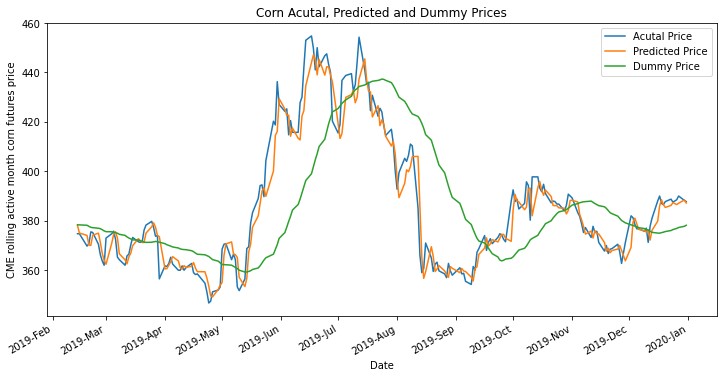

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

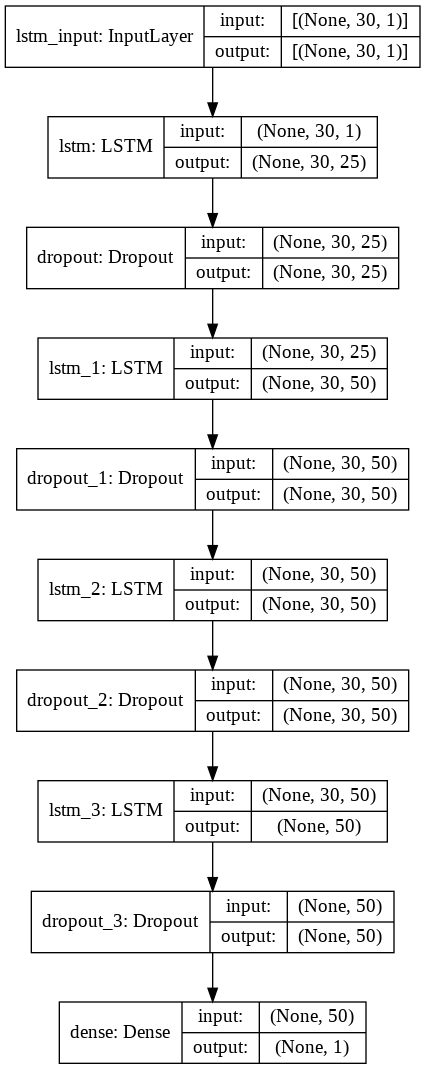

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.0035603106547257442
RMSE:  0.059668338796431596
MAE:  0.04217669530872667


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_Corn/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_Corn/assets
